<a href="https://colab.research.google.com/github/leessunj/IconSearch/blob/main/CS492I_Team39_IconSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisite: Mount your gdrive


In [3]:
# mount drive https://datascience.stackexchange.com/questions/29480/uploading-images-folder-from-my-system-into-google-colab
# login with your google account and type authorization code to mount on your googlbie drive.
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# 1. Image Processing
load image,
make image as sketch,
then make it as dataset

In [4]:
#이미지 전처리 관련 임포트
import cv2, sys
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import os
import pandas as pd
from pathlib import Path
from PIL import Image

In [5]:
# 경로 지정
root = '/gdrive/My Drive/CS492I/project'
category_path = root+'/Icons-50/'
category=os.listdir(category_path)

original_data_dir=[]
for i in range(len(category)):
  original_data_dir.append(category_path+category[i]+"/")

In [ ]:
#image = cv2.imread(imageroot+'/airplane/apple_0_airplane_arriving.png')
#image_gray = cv2.imread(imageroot+'/airplane/apple_0_airplane_arriving.png', cv2.IMREAD_GRAYSCALE)

In [ ]:
#이미지 전처리(흑백->라인따기)
def create_image_edge(image_file):
  image_bw=cv2.imread(image_file,0) #흑백으로 불러오기
  blur = cv2.GaussianBlur(image_bw, ksize=(3,3), sigmaX=0)
 ## cv2_imshow(blur)
  th=cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)
 ## cv2_imshow(th)
  return th

In [6]:
#이미지 전처리(흑백->라인따기)
#새로운 train 폴더 클래스 이름의 폴더 만들어 저장하기 
#root = '/gdrive/My Drive/CS492I/project'
train_dir = Path(root) / 'train'
train_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
for i in range(50):
  filelist=os.listdir(original_data_dir[i])
  train_category_dir = train_dir / f'{original_data_dir[i]}' 
  train_category_dir.mkdir(parents=True, exist_ok=True)
  for filename in filelist:
    fileimage=create_image_edge(original_data_dir[i]+filename)  
    cv2.imwrite(f'{train_category_dir}/{filename}' ,fileimage)
  print("Finished saving :"+original_data_dir[i])


In [24]:
imagelists=[]
filelist=os.listdir(train_dir)

for filename in filelist:
  file_dir=str(train_dir)+"/"+filename
  imagelists.extend( [file_dir+"/"+f for f in os.listdir(file_dir)  if (f.rfind('png') > -1)] )
#  print(len(imagelists))
#  print(filename)

90
blade
319
bird
608
boat
800
ball
1218
clock
1614
heart
1811
flower


In [44]:
testlists=[]
filelist=os.listdir(Path(root) / 'test')

for filename in filelist:
  file_dir=root+"/test/"+filename
  testlists.extend( [file_dir+"/"+f for f in os.listdir(file_dir)  if (f.rfind('jpg') > -1)] )
 # print(len(testlists))
 # print(filename)

1
heart
2
flower
3
clock
4
boat
5
blade
6
bird
7
ball


/gdrive/My Drive/CS492I/project/train/blade/samsung_3_crossed_swords.png


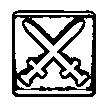

In [28]:
print(imagelists[0])
image=cv2.imread(imagelists[0])
cv2_imshow(image)
#input_image = Image.open(imagelists[0])

# 2. Load Pretrained Model
load pretrained model resnet34

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
import tensorflow as tf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

I used dataset for 7 class, ['ball', 'bird', 'blade', 'boat', 'clock', 'flower', 'heart']

In [54]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize(299), #299
    transforms.CenterCrop(299), #299
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = root #'./custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=2)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 1811
테스트 데이터셋 크기: 7
클래스: ['ball', 'bird', 'blade', 'boat', 'clock', 'flower', 'heart']


In [30]:
print(train_datasets)

Dataset ImageFolder
    Number of datapoints: 1811
    Root location: /gdrive/My Drive/CS492I/project/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


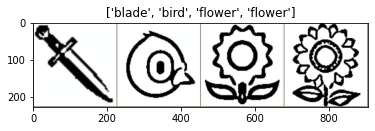

In [9]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [81]:
#model = models.inception_v3(pretrained=True)
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 7개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss() #뷴균형 학습셋 훈련에 용이
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [82]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.5960 Acc: 80.0110% Time: 51.2051s
#1 Loss: 0.2585 Acc: 92.2695% Time: 102.4438s
#2 Loss: 0.1319 Acc: 96.0243% Time: 154.2000s
#3 Loss: 0.1194 Acc: 96.5765% Time: 206.0426s
#4 Loss: 0.0718 Acc: 97.7913% Time: 256.9277s
#5 Loss: 0.0696 Acc: 98.1778% Time: 307.9004s
#6 Loss: 0.0535 Acc: 98.5091% Time: 359.5307s
#7 Loss: 0.0696 Acc: 97.8465% Time: 411.0719s
#8 Loss: 0.0544 Acc: 98.2882% Time: 461.8095s
#9 Loss: 0.0388 Acc: 98.8404% Time: 512.8650s


[Expected outcome: bird] (real answer: bird)


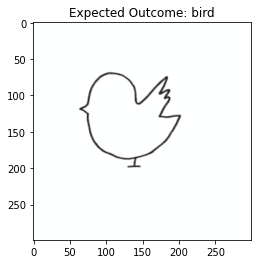

[Expected outcome: ball] (real answer: boat)


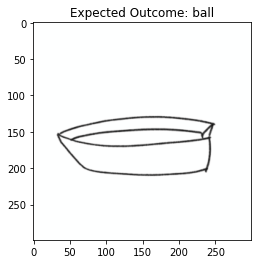

[Test Phase] Loss: 0.2740 Acc: 85.7143% Time: 2.3719s


In [83]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[Expected outcome: {class_names[preds[0]]}] (real answer: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='Expected Outcome: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

Check it! 

In [84]:
import io


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(imgpath):
    image = Image.open(imgpath)
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        print(preds)
        imshow(image.cpu().data[0], title='Expected: ' + class_names[preds[0]])

    return class_names[preds[0]]


tensor([6], device='cuda:0')


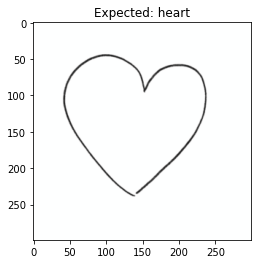

heart
tensor([5], device='cuda:0')


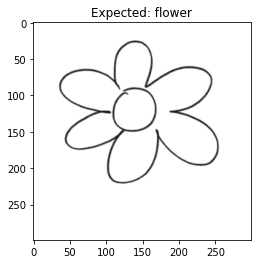

flower
tensor([4], device='cuda:0')


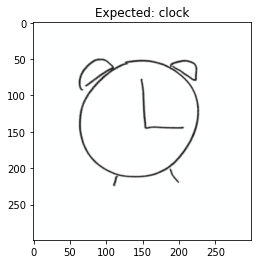

clock
tensor([0], device='cuda:0')


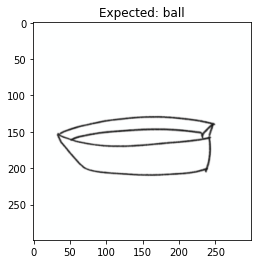

ball
tensor([2], device='cuda:0')


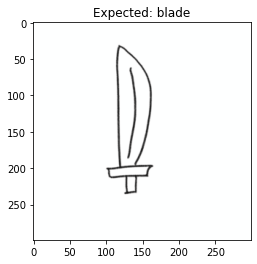

blade
tensor([1], device='cuda:0')


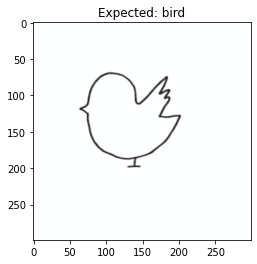

bird
tensor([0], device='cuda:0')


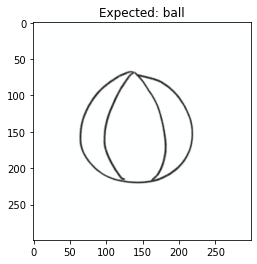

ball


In [85]:
for i in range(7):
  path = testlists[i]
  class_name = get_prediction(path)
  print(class_name)